# SOAM FLOW RUN TEST WITH MLFLOW

In the following notebook we present a simple quickstart to expose how to make a connection with a database, extract the data, transform it, generate a forecast and plot it using soam modules and methods in simple steps by using our soam flow, and track them using mlflow.

To see these modules and methods in a disaggregated manner and further explained check the [quickstart notebook](notebook/examples/quickstart.ipynb)

Our Soam Flows are based on Prefect Flows. To see further info on these please check this [prefect docs](https://docs.prefect.io/core/concepts/flows.html).

As a first step please set `TRACKING_IS_ACTIVE` to *True* on `soam/cfg.py` to enable mlflow tracking.

*Note: please ignore the # NBVAL_SKIP at the beginning of the cells!*

In [2]:
%%capture #hide
from soam.workflow.time_series_extractor import TimeSeriesExtractor
from muttlib.dbconn import get_client
import pandas as pd
import numpy as np
from soam.workflow.forecaster import Forecaster
from soam.models.prophet import SkProphet
from soam.utilities.utils import add_future_dates
from soam.reporting import mail_report
import datetime
from soam.core import SoamFlow
from prefect import task
from soam.plotting.forecast_plotter import ForecastPlotterTask
from soam.constants import PLOT_CONFIG
from copy import deepcopy
from pathlib import Path

## Extraction
DB Connection using `muttlib`. <br>
`SQL Query` constructed <br>
`SOAM Extractor` object initialization.

In [2]:
sqlite_cfg = {
    "db_type": "sqlite",
    "database": "soam_quickstart.db"
}

sqlite_client = get_client(sqlite_cfg)[1]

In [3]:
build_query_kwargs={
    'columns': '*',
    'timestamp_col': 'date',
    'start_date': "2021-03-01",
    'end_date': "2021-03-20",
    'extra_where_conditions': ["symbol = 'AAPL'"],
    'order_by': ["date ASC"]
}

In [4]:
extractor = TimeSeriesExtractor(db=sqlite_client, table_name='stock')

## Preprocessing
Tasks created upon functions based on custom transformations.

In [5]:
@task()
def transform_df_for_scaler(df: pd.DataFrame):
    data = np.array([df.avg_price])
    data = np.swapaxes(data, 0, 1)
    return data

@task()
def transform_df_format(df: pd.DataFrame):    
    df = df[['date', 'avg_price']]
    df.rename(columns = {
        'date': 'ds',
        'avg_price': 'y'}, inplace = True)
    df.ds =  pd.to_datetime(df.ds, infer_datetime_format=True)
    df = add_future_dates(df, periods=7, frequency="d")
    return df

## Forecasting
Forecasting model selected: `FBProphet`. <br>
`SOAM Forecaster` object initialization.

In [6]:
my_model = SkProphet(weekly_seasonality=False, daily_seasonality=True)
forecaster = Forecaster(my_model, output_length=7)

## Plotting and Reporting
Plotting task based on the `SOAM Forecast Plotter` object.

In [7]:
plot_config = deepcopy(PLOT_CONFIG)
forecast_plotter = ForecastPlotterTask(path = Path('img/applestockprice'), metric_name = "Apple's Stock Price", plot_config = plot_config)

In [8]:
# NBVAL_SKIP

# this refer to the start and end of the historic values. they are used since they are part of plot filename. format: yyyymmddhh.
start_date='2021030100'
end_date='2021031900'

# SoaMFlow

Putting all together using `SoaMFlow`.

In [9]:
# NBVAL_SKIP
with SoamFlow(name = "flow") as flow:
    # EXTRACTION
    df = extractor(build_query_kwargs)
    # PRE PROCESSING
    data = transform_df_for_scaler(df = df)
    df = transform_df_format(df = df)
    # FORECASTING
    predictions, time_series, model = forecaster(time_series=df)
    # PLOTTING
    forecast_plotter(time_series, predictions)


<Success: "All reference tasks succeeded.">

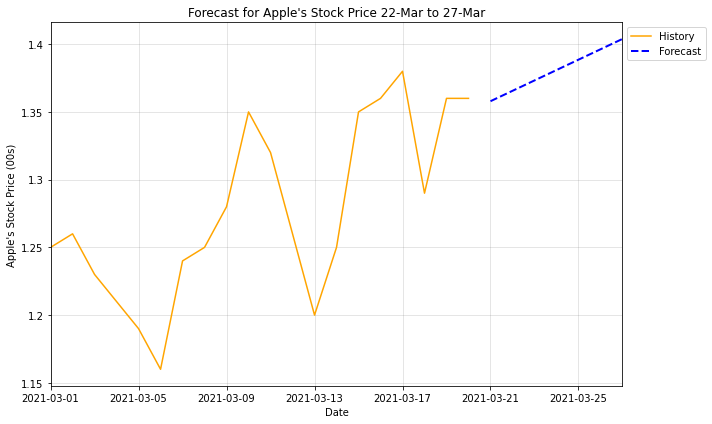

In [10]:
import warnings
warnings.filterwarnings('ignore')
# NBVAL_SKIP
flow.run()

Uncomment and run the next code cell and click on the link it generates

In [11]:
#!mlflow ui

[2021-06-11 16:24:48 -0300] [1579] [INFO] Starting gunicorn 20.1.0
[2021-06-11 16:24:48 -0300] [1579] [INFO] Listening at: http://127.0.0.1:5000 (1579)
[2021-06-11 16:24:48 -0300] [1579] [INFO] Using worker: sync
[2021-06-11 16:24:48 -0300] [1581] [INFO] Booting worker with pid: 1581
^C
[2021-06-11 16:30:24 -0300] [1579] [INFO] Handling signal: int
[2021-06-11 16:30:24 -0300] [1581] [INFO] Worker exiting (pid: 1581)


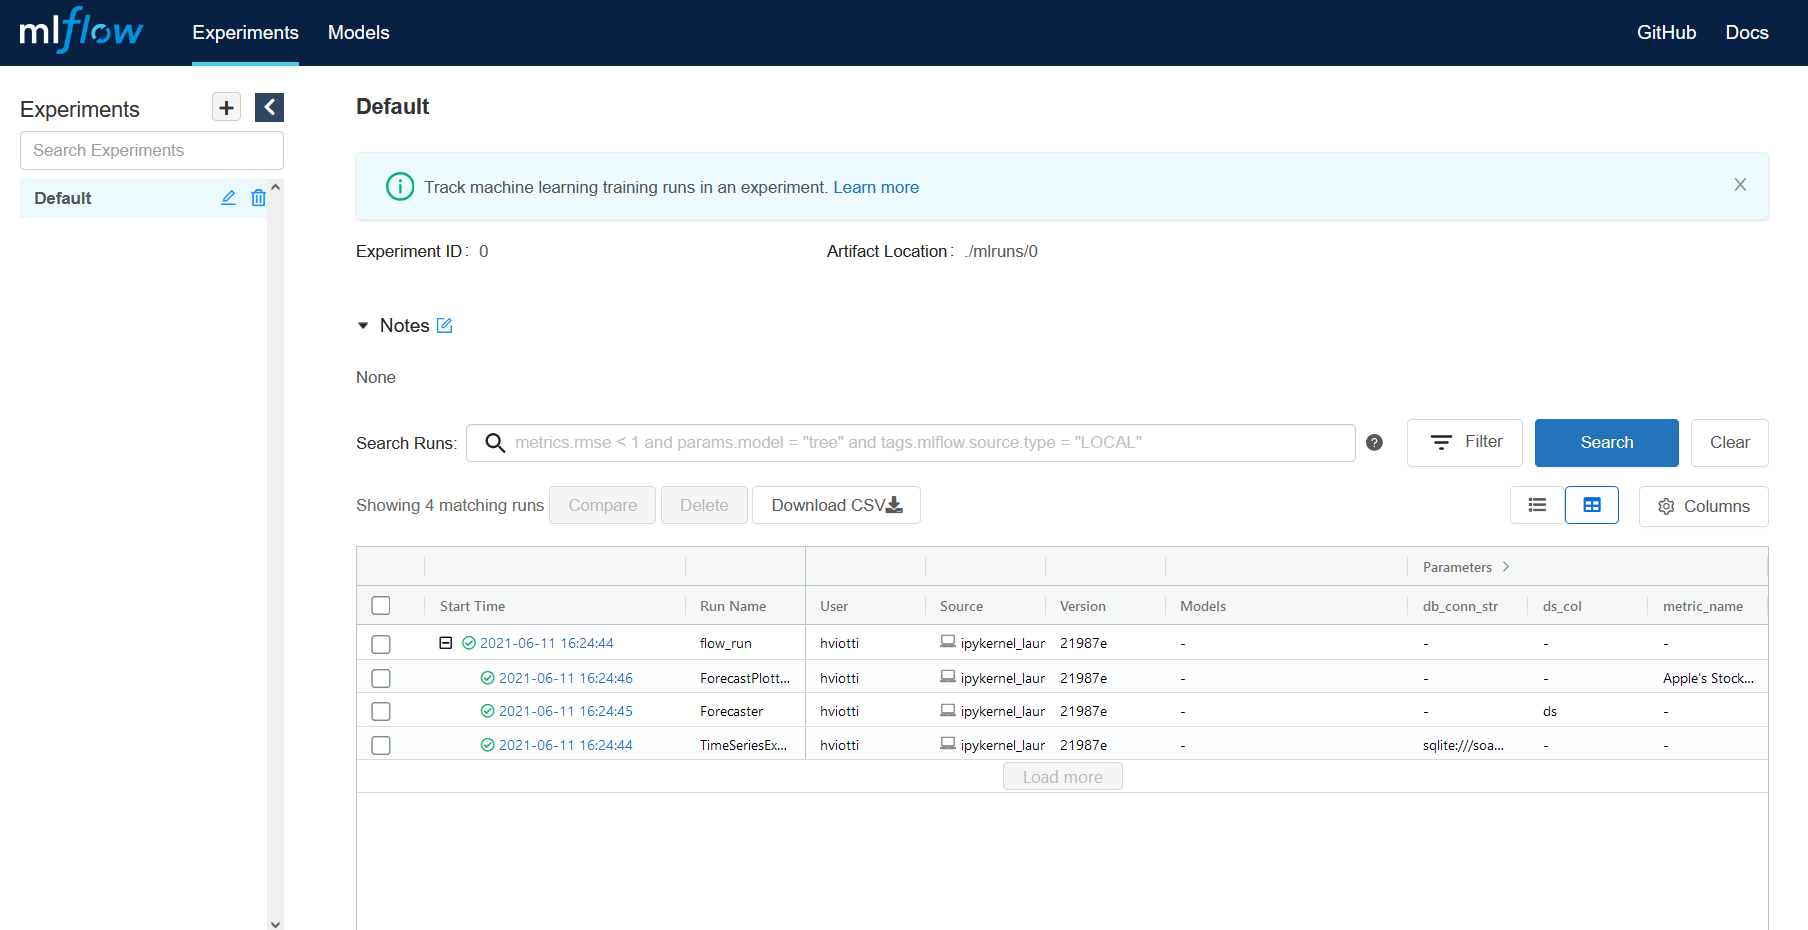

In [13]:
from IPython.display import display, Image

display(Image(filename='img/mlflow_tracking.png'))

<center>Voilà!</center>